Simulation experiments for the Misspecification of Domain Generalization Benchmarks: Accuracy on the Line

In [1]:
# Standard library imports
import builtins

# Third-party library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from scipy import stats
from scipy.stats import norm
from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

# Define experimental constants as global variables
builtins.n_samples = 500
builtins.n_plot_samples = 100
builtins.n_features = 2
builtins.mu_c = np.array([1, 1])
builtins.mu_e = np.array([1, 1])
builtins.Sigma_c = np.array([[1, 0.0], [0.0, 1]])
builtins.Sigma_e = np.array([[1, 0.0], [0.0, 1]])

builtins.p_y1 = 0.5
builtins.p_noise = 0.25

builtins.n_Ms = 50

from utils import (
generate_Ms,
generate_distribution,
generate_mixture_distribution,
train_and_test_model,
get_inner_product,
)

In [3]:
# Constants
INCLUDE_NEGATIVE_DEFINITE_M = True  # Controls whether to include negative definite Ms
M_NORM_BOUND = 50  # Maximum norm for generated Ms

# Generate training environment Ms
# Option 1: Using random Ms (current implementation)
training_Ms = [np.random.randn(n_features, n_features) for _ in range(n_Ms)]

# Define test environments
# In-distribution test environment
id_M = np.eye(n_features)

# Out-of-distribution test environments
# 1. Simple scaled identity Ms
base_ood_Ms = [
    np.eye(n_features),      # Identity
    -1 * np.eye(n_features)  # Negative identity
]

# 2. Generate additional structured Ms
additional_ood_Ms = generate_Ms(
    n=n_features,
    d=4,
    bound=M_NORM_BOUND,
    include_nd=INCLUDE_NEGATIVE_DEFINITE_M,
)

# 3. Generate random Ms
random_ood_Ms = [
    np.random.randn(n_features, n_features)
    for _ in range(10)
]

# 4. Generate scaled identity Ms based on M norms
scaled_identity_Ms = []
for i, M in enumerate(additional_ood_Ms):
    M_norm = np.linalg.norm(M)
    if i % 2 == 0:
        scaled_identity_Ms.append(M_norm * np.eye(n_features))
    else:
        scaled_identity_Ms.append(-M_norm * np.eye(n_features))

# Combine all OOD Ms
ood_Ms = (random_ood_Ms +
                additional_ood_Ms +
                base_ood_Ms +
                scaled_identity_Ms)

# Generate distributions for training and testing
id_distribution = generate_distribution(id_M)
ood_distributions = [generate_distribution(M) for M in ood_Ms]
train_distributions = [generate_distribution(M) for M in training_Ms]

In [4]:
# Train models and collect results for each training distribution
ood_accuracies = []
trained_models = []

# Prepare ID and OOD datasets for evaluation
ood_datasets = [(id_distribution['X'], id_distribution['Y'])]
ood_datasets.extend([(dist['X'], dist['Y']) for dist in ood_distributions])

# Train and evaluate models
for train_dist in tqdm(train_distributions, desc="Training and OOD evaluation"):
    # Train model and evaluate on ID and OOD sets
    model, accuracies = train_and_test_model(
        train_features=train_dist['X'],
        train_labels=train_dist['Y'],
        test_datasets=ood_datasets  # Note: parameter name from utils.py
    )

    # Store results
    ood_accuracies.append(accuracies)
    trained_models.append(model)

Training and OOD evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

In [5]:
# Convert accuracies to numpy array and apply probit transformation
ood_accuracies_array = np.array(ood_accuracies)
probit_ood_accuracies = norm.ppf(ood_accuracies_array)

,$\|M\|$,$\|M_{normalized} - I\|$,$\sigma_{min}(M)$,$\sigma_{max}(M)$,slope,intercept,Pearson R,p-value,standard errors
0,2.198571,1.326228,-0.701201+0.000000j,2.065544+0.000000j,0.480874,0.155855,0.459900,7.790179e-04,0.134013
1,2.948731,1.266187,-0.724582+0.000000j,2.783932+0.000000j,1.100213,-0.009291,0.957429,1.501018e-27,0.047880
2,1.298508,0.885951,0.719078-0.544521j,0.719078+0.544521j,0.714572,-0.066905,0.811330,9.000785e-13,0.074315
3,2.177823,1.560777,-0.756937+0.000000j,1.371056+0.000000j,0.853411,0.015915,0.951442,3.300119e-26,0.039853
4,2.128365,1.693854,-0.841872+0.000000j,0.981129+0.000000j,-0.727811,0.164797,-0.845754,1.080809e-14,0.066275
5,1.197449,0.786970,0.264253+0.000000j,1.161117+0.000000j,0.851786,0.089056,0.845569,1.109778e-14,0.077623
6,1.480486,1.695652,-0.936253+0.000000j,1.028609+0.000000j,-0.827011,0.164360,-0.984211,9.302756e-38,0.021467
7,2.929645,1.465249,-0.426687+0.000000j,1.676248+0.000000j,0.916317,0.053570,0.803708,2.123033e-12,0.097918
8,1.475580,2.190698,-1.426876+0.000000j,0.099475+0.000000j,0.114289,0.170043,0.372108,7.792083e-03,0.041148
9,2.195339,1.977787,-1.969703+0.000000j,0.969020+0.000000j,0.599835,-0.108834,0.744977,5.508780e-10,0.077527


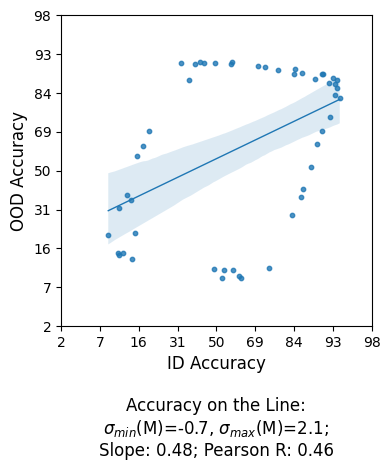

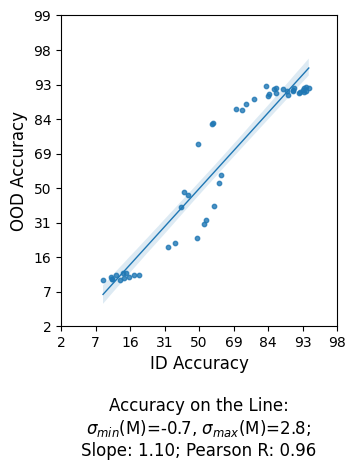

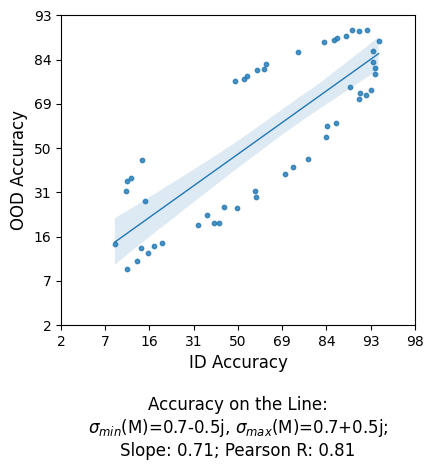

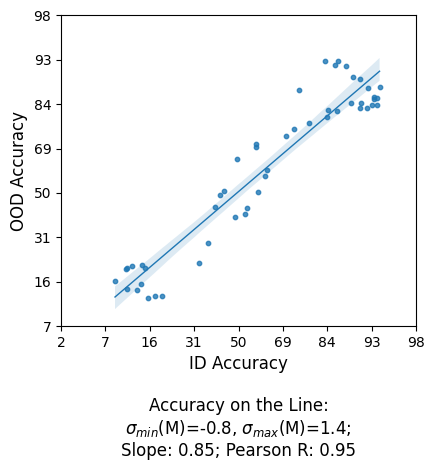

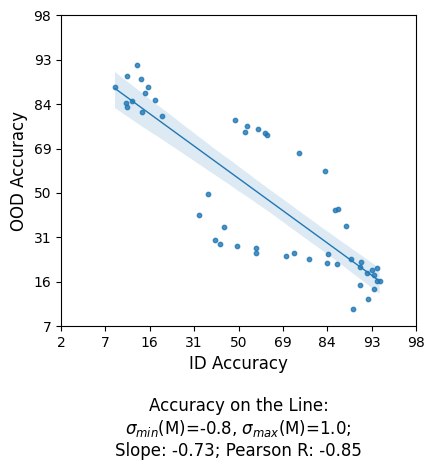

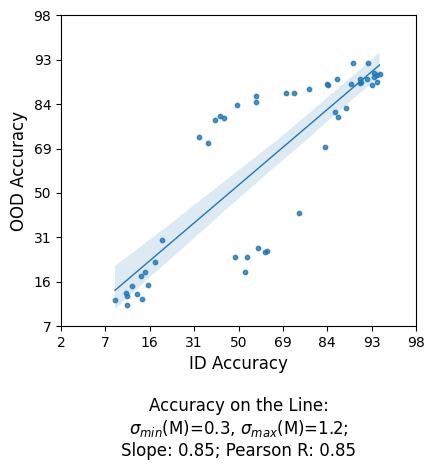

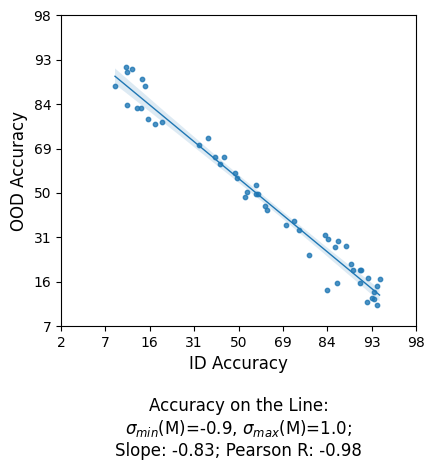

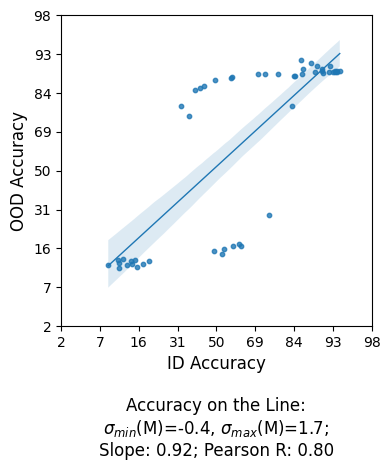

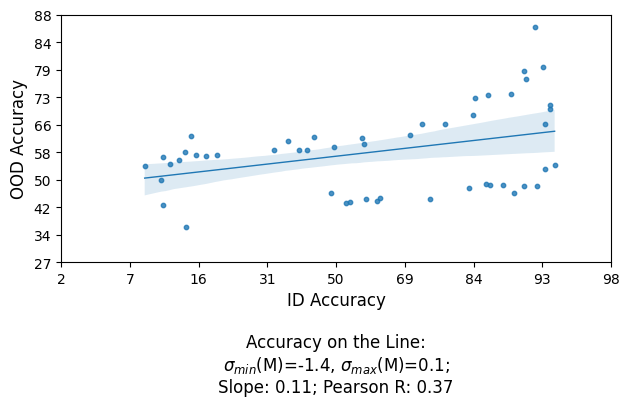

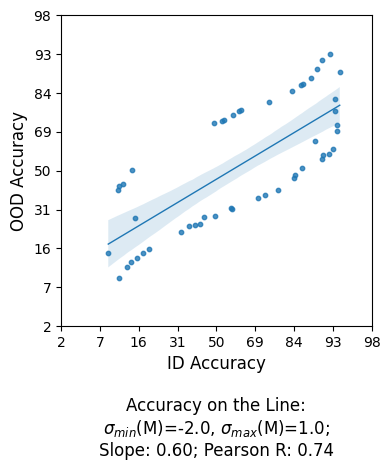

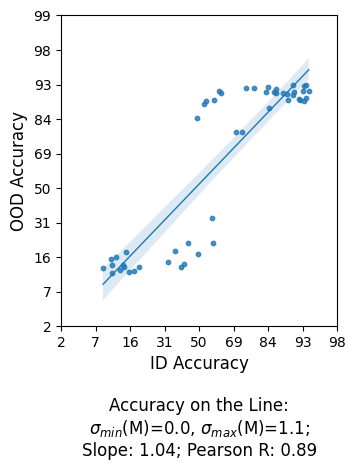

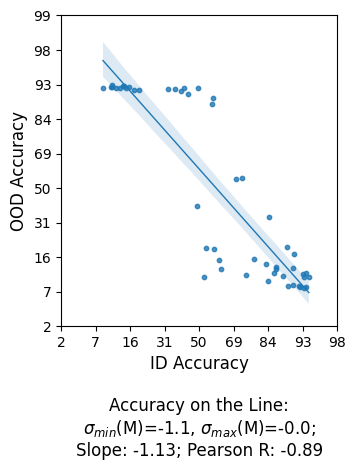

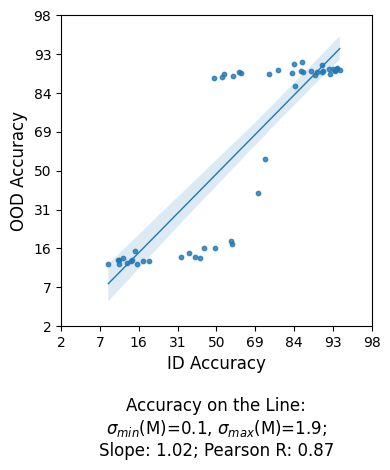

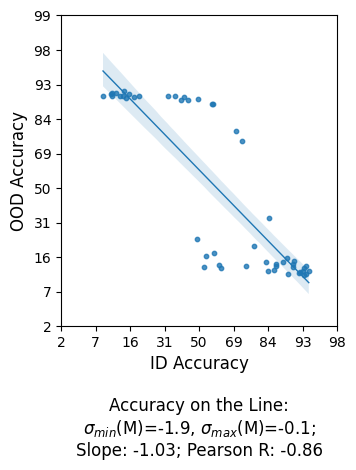

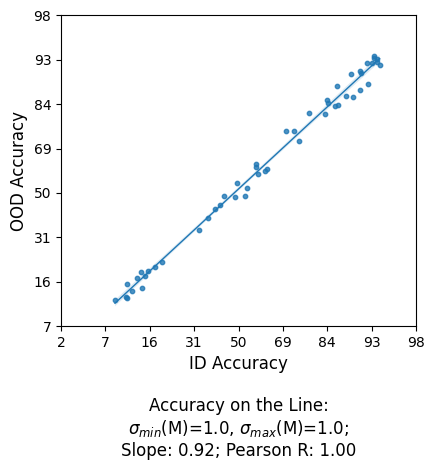

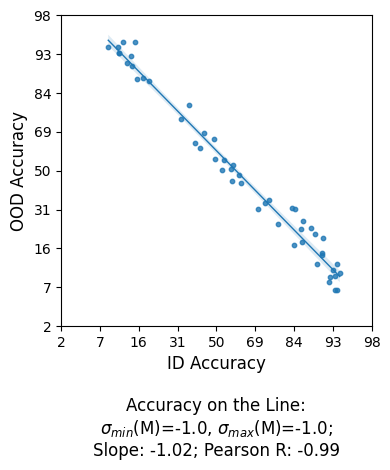

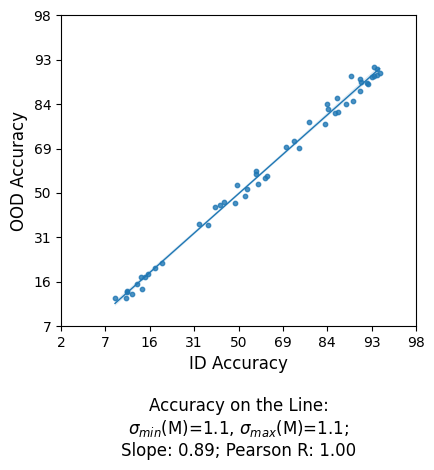

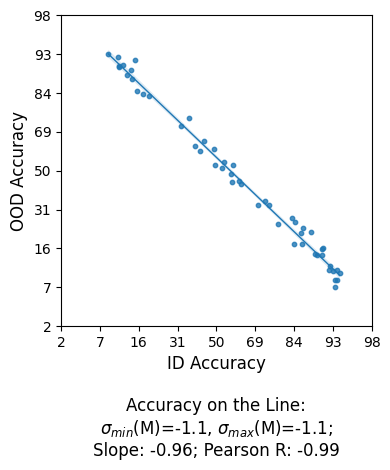

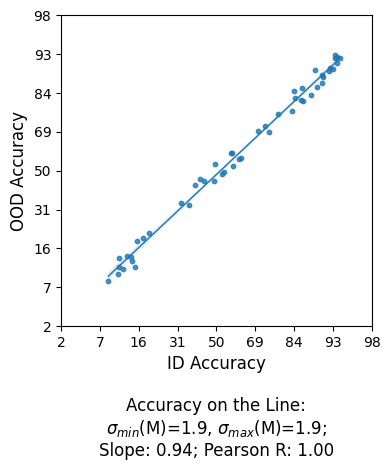

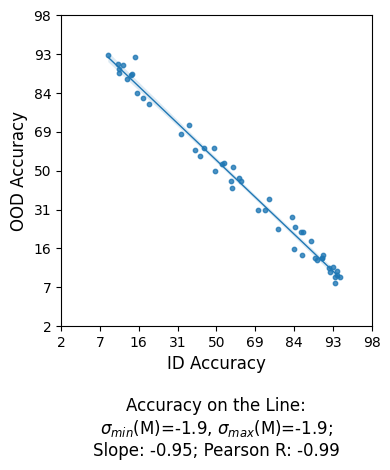

In [6]:
# Analyze relationship between ID and OOD performance
analysis_results = []

# Create scatter plots for each OOD setting
for i in range(probit_ood_accuracies.shape[1] - 1):
    # Setup plot
    _, ax = plt.subplots()

    # Get ID and OOD probit accuracies
    id_probit = probit_ood_accuracies[:, 0]
    ood_probit = probit_ood_accuracies[:, i + 1]

    # Create regression plot
    sns.regplot(
        x=id_probit,
        y=ood_probit,
        ax=ax,
        scatter_kws={'s': 10},  # Smaller scatter points
        line_kws={'linewidth': 1}  # Thinner regression line
    )

    # Compute regression statistics
    slope, intercept, r_value, p_value, std_err = stats.linregress(id_probit, ood_probit)

    # Configure probability scale ticks
    original_xticks = ax.get_xticks()
    original_yticks = ax.get_yticks()

    # Convert probit values to percentages
    prob_xticks = norm.cdf(original_xticks)
    prob_yticks = norm.cdf(original_yticks)

    # Update tick labels
    ax.set_xticks(original_xticks)
    ax.set_yticks(original_yticks)
    ax.set_xticklabels([f"{100*p:.0f}" for p in prob_xticks])
    ax.set_yticklabels([f"{100*p:.0f}" for p in prob_yticks])

    # Get current OOD M and its properties
    ood_M = ood_Ms[i]
    M_norm = np.linalg.norm(ood_M)
    normalized_M_diff = np.linalg.norm((ood_M / M_norm) - np.eye(n_features))

    # Compute eigenvalue statistics
    eigenvalues = np.linalg.eigvals(ood_M)
    min_eigenvalue = np.min(eigenvalues)
    max_eigenvalue = np.max(eigenvalues)

    # Store analysis results
    analysis_results.append([
        M_norm,
        normalized_M_diff,
        min_eigenvalue,
        max_eigenvalue,
        slope,
        intercept,
        r_value,
        p_value,
        std_err
    ])

    # Set plot labels and formatting
    plt.xlabel(
        "ID Accuracy\n\n"
        f"Accuracy on the Line:\n"
        r"$\sigma_{min}$" + f"(M)={min_eigenvalue:.1f}, "
        r"$\sigma_{max}$" + f"(M)={max_eigenvalue:.1f};\n"
        f"Slope: {slope:.2f}; Pearson R: {r_value:.2f}",
        size=12
    )
    plt.ylabel('OOD Accuracy', size=12)

    # Make plot square
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()

# Create results dataframe
results_df = pd.DataFrame(
    analysis_results,
    columns=[
        r"$\|M\|$",
        r"$\|M_{normalized} - I\|$",
        r"$\sigma_{min}(M)$",
        r"$\sigma_{max}(M)$",
        "slope",
        "intercept",
        "Pearson R",
        "p-value",
        "standard errors",
    ]
)
display(results_df)